In [69]:
# Built-in
from pathlib import Path

# Third-party
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks_cwt
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np

# Local imports
from polya.utils import smooth

styles = ['../polya.mplstyle']


In [70]:
experiment = 'rip-bpa'

datadir = Path("../data/bpa")/experiment

fnames = sorted(list(datadir.glob("*.txt")))
fnames

[PosixPath('../data/bpa/rip-bpa/180612_cytosol frac RIP_Profile_15d.txt'),
 PosixPath('../data/bpa/rip-bpa/180710 cyto barricade RIP 2nd Profile_5d.txt'),
 PosixPath('../data/bpa/rip-bpa/190809 RIP cyto bpa_Profile_10d.txt'),
 PosixPath('../data/bpa/rip-bpa/200507 RIP-cytoBPA.txt')]

In [129]:
smpidx = 3
inpfpath = fnames[smpidx]
work = inpfpath.name
print(work)

samples = {
    "rip-bpa": ["Input", "LARP1", "LARP4"],
    "kd-bpa": ["siNC", "siLARP1", "siLARP4_4B"],
}[experiment]

# Read the data
df = pd.read_csv(inpfpath, sep='\t', header=5, index_col=0).dropna()
print(list(df.columns))
df = df[['Decade1'] + samples + ['Decade2']]
df.head(3)

200507 RIP-cytoBPA.txt
['Decade1', 'Input', 'LARP1', 'LARP4', 'LARP4B', 'Decade2']


,Decade1,Input,LARP1,LARP4,Decade2
(pixel),,,,,
0,145362.0735,146368.8661,165762.8858,154543.2293,150408.9270
1,148393.7948,148800.2324,162522.7034,161981.6148,149454.8735
2,141866.4092,146807.8849,160101.7130,163956.0270,152658.9649


### Find the marker peaks

[  18  301  754 1101 1363 1564 1725 1851 1958 2047 2381 2783]


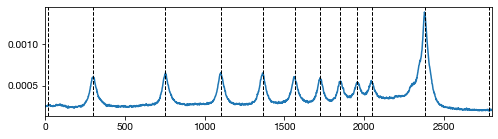

In [130]:
marker_colidx = 0

# Normalize signal intensities by lane and reverse it
df = df.div(df.sum(), axis="columns")[::-1].reset_index(drop=True)

marker_density = df.iloc[:,marker_colidx]
peaks_found = find_peaks_cwt(marker_density.dropna(), np.arange(17, 100), min_snr=1, noise_perc=10) # peak calling
print(peaks_found)

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in peaks_found: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
# ax.set_xticks(peaks_found)
# ax.set_xticklabels(np.arange(0,len(peaks_found)))

plt.show()

### Manually add or remove the marker peaks

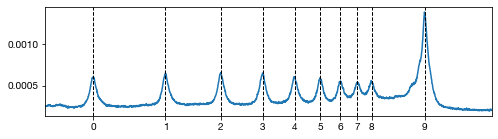

In [131]:
to_add = {
    '190729-1 HeLa cyto kd-bpa.txt':[1690],
    '190729-2 A549 cyto kd-bpa.txt':[1690],
}.get(work, [])
to_remove ={
    '180612_cytosol frac RIP_Profile_15d.txt': [17, 455, 2287],
    '200507_T11_barricade RIP_cyto_BPA_Profile_20d.txt': [18, 2783],
    '180710 cyto barricade RIP 2nd Profile_5d.txt': [17, 189, 981, 2632],
    '190809 RIP cyto bpa_Profile_10d.txt': [16, 2542],
    '200507 RIP-cytoBPA.txt':[18, 2783],

    
    '181126 Barricade_KD_cytosol_fraction_BPA_6d_labeled.txt':[17, 2472],
    '190729-1 HeLa cyto kd-bpa.txt':[15, 2099, 2252, 2384, 2484, 2611],
    '190729-2 A549 cyto kd-bpa.txt':[15, 2099, 2252, 2384, 2484, 2611],
    '200507 T11_barricade KD_cyto_BPA_half decrease_Profile_17d_named.txt':[17, 2456],
#     'rip-bpa':[20, 2780],
#     'kd-bpa': [2453],
}[work]

marker_peaks = list(peaks_found) + to_add
marker_peaks = sorted(list(set(peaks_found) - set(to_remove)))

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in marker_peaks: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
for x in to_add: ax.axvline(x, color="orange", ls="--", lw=1)
ax.set_xticks(marker_peaks)
ax.set_xticklabels(np.arange(0,len(marker_peaks)))

plt.show()

In [132]:
marker_labels = [20,30,40,50,60,70,80,90,100,150]

assert len(marker_labels) == len(marker_peaks)

### Draw plots

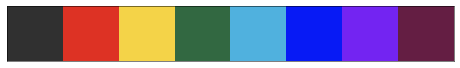

{'Input': '#303030', 'LARP1': '#DD3224', 'LARP4': '#F4D348'}


In [133]:
with plt.style.context(styles):
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    sns.palplot(palette)
    plt.show()
    
    colors = dict(zip(samples, palette))
    print( colors )

Plot separately

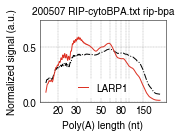

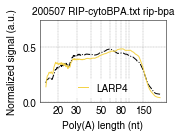

In [134]:
# Draw a figure

savefig = False
minifig = True


# samples for embedding in every figure
embedsmp = ["Input"] 
# embedsmp = ["siNC"]
subsamples = samples

figsize = [4.5, 3]

if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(np.array(figsize) / 2)
with plt.style.context(styles):
    for si, smp in enumerate(subsamples[1:]):
        fig, ax = plt.subplots(figsize=figsize)

        for esmp in embedsmp:
            density = smooth(np.array(df.loc[:,esmp]), 50) * 1000
            ax.plot(density, ls="-.", color="black", label="")
                
        density = smooth(np.array(df.loc[:,smp]), 50) * 1000
        ax.plot(density, color=colors[smp], label=smp)
        
        ax.grid(True)
        ax.set_ylim([0,0.75])
        ax.set_yticks([0,0.5])
        ax.legend(loc="lower center", ncol=2, columnspacing=0.5, handlelength=1.0)
          
        ax.set_xticks(marker_peaks)
        marker_sizes = [20,30,50,80,150]
        ax.set_xticklabels([m if m in marker_sizes else "" for m in marker_labels])

        ## Shared labels
        ax = fig.add_subplot(111, frameon=False)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("Poly(A) length (nt)", labelpad=18)
        ax.set_ylabel("Normalized signal (a.u.)", labelpad=23)
        ax.set_title(f"{work.split('_')[0]} {experiment}", fontsize="medium")


        fname_adduct = ""
        if minifig: fname_adduct += "_mini"
        if savefig is True:
            outfigdir = Path("../plots")
            outfigname = f"{experiment}_{work.split('_')[0]}_{smp}" + fname_adduct + ".pdf"
            outfigpath = outfigdir/outfigname
            print( outfigpath )

            fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

        plt.show()


log2fc 1d heatmap

../plots/rip-bpa_200507_LARP4_log2fc_mini.pdf saved


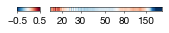

In [135]:
savefig = True
ctrl, tret = "Input", "LARP4"
# ctrl, tret = "siNC", "siLARP4_4B"
vmin, vmax = -0.5, 0.5
markers_to_include = [20, 30, 50, 80, 150]

ctrl_intensity = smooth(np.array(df.loc[:,ctrl]), 50) * 1000
tret_intensity = smooth(np.array(df.loc[:,tret]), 50) * 1000
log2fc = np.log2(tret_intensity / ctrl_intensity)
# log2fc = df[tret].div(df[ctrl]).map(np.log2)
figsize = 2.6, 0.08

with plt.style.context(['../polya.mplstyle', '../mini.mplstyle', '../tick.mplstyle']): 
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(np.asarray(log2fc).reshape(-1,1).T, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)

    marker_dict = dict(zip(marker_labels, marker_peaks))
    xticks = [marker_dict[m] for m in markers_to_include]
    ax.set_xticks(xticks)
    ax.set_xticklabels(markers_to_include)
    ax.set_yticks([])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="20%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.solids.set_rasterized(True)

    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"{experiment}_{work.split()[0]}_{tret}_log2fc" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath, 'saved' )

        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

plt.show()

x-linearized log2fc 1d heatmap

In [136]:
# Add the size column to linearize the range within marker limits

sizes = list()
for pi, size in enumerate(marker_labels):
    if pi + 1 == len(marker_peaks): break
    pos = marker_peaks[pi]
    nextpos = marker_peaks[pi+1]
    nextsize = marker_labels[pi+1]
    nsigs = nextpos - pos
    sizes += list(np.linspace(size, nextsize, nsigs+1)[:-1])
sizes += [marker_labels[-1]]
df["size"] = None
df.iloc[marker_peaks[0]:marker_peaks[-1]+1, -1] = sizes

In [137]:
# Draw a x-linearised log2 foldchange of the signals
nbins = 1000
binsize = (marker_peaks[-1] - marker_peaks[0]) / nbins
df_temp = df.copy()
df_temp.loc[:, "binid"] = df_temp.loc[:,"size"] // binsize
df_binned = df_temp.groupby("binid").agg(np.sum)

def get_size_from_binid(bid):
    return bid * binsize + (binsize / 2)

df_binned.head(3)

,Decade1,Input,LARP1,LARP4,Decade2
binid,,,,,
9.0,0.017801,0.012013,0.013324,0.012942,0.015613
10.0,0.026510,0.031259,0.037443,0.032935,0.024354
11.0,0.023509,0.032062,0.039541,0.031606,0.022528


../plots/rip-bpa_200507 RIP-cytoBPA.txt_LARP4_linearized_log2fc_mini.pdf saved


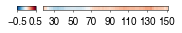

0.21226742401542623 134.16
0.1966582610406148 130.0
0.19637353811525432 127.92000000000002
0.19401096953936475 132.07999999999998
0.17973922760507546 105.04
0.17502706481899596 107.12
0.17426021425001298 125.84000000000002
0.17130355767141364 136.24
0.1676698064601419 109.2
0.16755771941162614 121.68
0.1655870484873365 102.96000000000001
0.1633052103350135 123.76
0.16297547012218136 115.44000000000001
0.16191909629003834 113.36000000000001
0.16073916359917867 100.88000000000001
0.1569649174444694 111.28000000000002
0.15123293908314092 117.52000000000001
0.1488050161144155 119.60000000000001
0.14744480645248229 140.4
0.14503126404713637 98.80000000000001
0.14224309703826918 96.72000000000001
0.13744503399181737 138.32
0.13503609066042155 142.48
0.13397506071024456 144.56
0.12716346212603305 82.16000000000001
0.12575745547616124 146.64
0.12392168825171411 94.64000000000001
0.12373036329796651 78.00000000000001
0.12053464252129491 150.79999999999998
0.12024472005266998 86.32000000000001
0

In [139]:
savefig = True
minifig = True

figsize = 5.4, 2.4

if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(np.array(figsize) / 2)
    
# ctrl, tret = "siNC", "siLARP4_4B"
# vmin, vmax = -0.4, 0.4
ctrl, tret = "Input", "LARP4"
vmin, vmax = -0.5, 0.5

with plt.style.context(styles + ["../tick.mplstyle"]):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    log2fc = np.log2(df_binned.loc[:, tret] / df_binned.loc[:, ctrl])

    d = np.vstack((log2fc, log2fc))

    im = ax.imshow(d, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)

    xticklabels = list(range(30, 151, 20))
    xticks = (xticklabels // binsize) - (marker_labels[0] // binsize)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="15%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.solids.set_rasterized(True)

    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"{experiment}_{work.split('_')[0]}_{tret}_linearized_log2fc" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath, 'saved' )

        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

    plt.show()

for i in log2fc.sort_values(ascending=False).head(50).index:
    print( log2fc.loc[i], get_size_from_binid(i) )

Plot combined

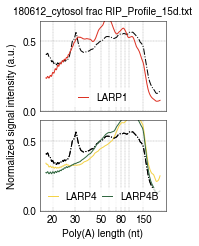

In [62]:
# Draw a figure

savefig = False
minifig = True


# samples for embedding in every figure
embedsmp = ["Input"] 
# embedsmp = ["siNC"]
subsamples = samples
nrows = 2

figsize = [4.5, 3 + 2 * nrows]

styles = ["barricade"]
if minifig is True: 
    styles.append("mini")
    figsize = list(np.array(figsize) / 2)
with plt.style.context(styles):

    fig, axes = plt.subplots(nrows, 1, figsize=figsize, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.1)

    axi = 0
    for si, smp in enumerate(subsamples[1:]):
        ax = axes.ravel()[axi]

        for esmp in embedsmp:
            density = smooth(np.array(df.loc[:,esmp]), 50) * 1000
            ax.plot(density, ls="-.", color="black", label="")
                
        density = smooth(np.array(df.loc[:,smp]), 50) * 1000
        ax.plot(density, color=colors[smp], label=smp)
        
        ax.grid(True)
        ax.set_ylim([0,0.65])
        ax.set_yticks([0,0.5])
        ax.legend(loc="lower center", ncol=2, columnspacing=0.5, handlelength=1.0)
        
        if smp != 'LARP4': axi += 1
          
    ax.set_xticks(marker_peaks)
    marker_sizes = [20,30,50,80,150]
    ax.set_xticklabels([m if m in marker_sizes else "" for m in marker_labels])
    
    ## Shared labels
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Poly(A) length (nt)", labelpad=18)
    ax.set_ylabel("Normalized signal intensity (a.u.)", labelpad=23)
    ax.set_title(work, fontsize="medium")

    
    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"bpa_densitogram_{work}_{''.join(subsamples[1:])}" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath )
        
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    